In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import multivariate_normal

In [2]:
#  Parameters
FILES = ['EMGaussian.train', 'EMGaussian.test']
NUM_MEANS = 4
MEANS_COLOR = ['red', 'blue', 'green', 'orange']
CLUSTER_MEANS_COLOR = ['pink', 'cyan', 'green', 'yellow']
NUM_ITER = 100
EPSILON = 1e-8

train_data = np.loadtxt('hwk3data/' + FILES[0])
test_data = np.loadtxt('hwk3data/' + FILES[1])

In [3]:
#  Computes loss and responsibilities for EM
def compute_loss(data, pi, mu, cov):
    n, _ = data.shape
    resp = np.array([pi[i] * multivariate_normal(mean=mu[i], cov=cov[i]).pdf(data) for i in range(NUM_MEANS)]).T
    #  normalize
    resp /= resp.sum(axis=1, keepdims=1)

    loss = np.array([np.log(pi[i]) + np.log(multivariate_normal(mean=mu[i], cov=cov[i]).pdf(data))
                     for i in range(NUM_MEANS)])
    loss = np.sum(loss.T * resp) / n
    return resp, loss

In [4]:
#  Function to compute k means
def get_k_means(data):
    n, d = data.shape
    loss_list = list()
    centers_list = [np.random.uniform(low=data.min(), high=data.max(), size=[NUM_MEANS,d])]
    for iter in range(NUM_ITER):
        #  E Step
        resp = np.sum((centers_list[iter][:,np.newaxis]-data[np.newaxis::])**2, axis=d)
        assign = resp.argmin(axis=0)

        #  M Step
        new_centers = np.array([np.mean(data[assign == j], axis=0) for j in range(NUM_MEANS)])
        centers_list.append(new_centers)
        loss = np.sum(np.min(np.sum((centers_list[iter+1][:,np.newaxis]-data[np.newaxis::])**2, axis=d), axis=0))/n
        loss_list.append(loss)
        print("current mean square deviation at iter {0}: {1}".format(iter, loss))
        if iter > 1:
            if loss_list[iter-1] - loss_list[iter] < EPSILON:
                break
    return centers_list, loss_list, assign

In [5]:
#  Function to generate plots
def plot_k_means(clusts, assign):
    plt.figure()
    for j in range(NUM_MEANS):
        plt.scatter(x=train_data[assign == j, 0], y=train_data[assign == j, 1], color=MEANS_COLOR[j], alpha=0.3, s=20)
        plt.scatter(x=clusts[j, 0], y=clusts[j, 1], color=MEANS_COLOR[j], marker=(5, 2), s=40)

    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.title('K Means')

    plt.savefig('../K_means_img')
    plt.show()

In [6]:
k_means, losses, assign = get_k_means(train_data)

current mean square deviation at iter 0: 10.44195742055406
current mean square deviation at iter 1: 8.058721710651
current mean square deviation at iter 2: 7.1842795591207524
current mean square deviation at iter 3: 6.757459963513813
current mean square deviation at iter 4: 6.560915961680131
current mean square deviation at iter 5: 6.4999329664068375
current mean square deviation at iter 6: 6.488493329167502
current mean square deviation at iter 7: 6.48052717825385
current mean square deviation at iter 8: 6.477248331949982
current mean square deviation at iter 9: 6.475559192992271
current mean square deviation at iter 10: 6.475559192992271


In [7]:
#  Get cluster centers
print(k_means[-1])

[[-2.24034752  4.12744772]
 [ 3.80280826  5.10467248]
 [-3.81879354 -4.27423441]
 [ 3.33557966 -2.644529  ]]


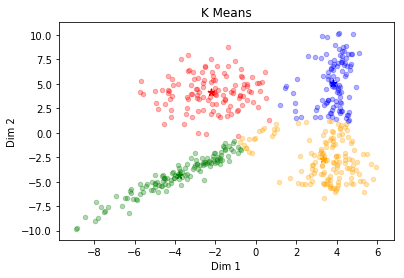

In [8]:
plot_k_means(clusts=k_means[-1], assign=assign)

In [9]:
#  Initialize RVs for EM
init_mu = k_means[-1]
init_resp = assign

In [10]:
#  Computes EM clusters with spherical mean
def spherical_EM(data, init_mu, init_resp):
    #  Initialize variables
    n, d = data.shape
    mu_list = [init_mu]
    pi_list = [np.array([init_resp.tolist().count(i)/n for i in range(NUM_MEANS)])]
    cov_list = [np.array([np.identity(d)*data[init_resp==i].var() for i in range(NUM_MEANS)])]

    losses = []
    for iter_em in range(NUM_ITER):
        pi = pi_list[iter_em]
        mu = mu_list[iter_em]
        cov = cov_list[iter_em]

        # E Step
        resp, loss = compute_loss(data, pi, mu, cov)

        # Compute loss
        losses.append(loss)

        if iter_em > 1:
            if losses[iter_em] - losses[iter_em-1] < EPSILON:
                break

        # M Step
        new_pi = resp.mean(axis=0)
        pi_list.append(new_pi)

        new_mu = np.dot(resp.T, data)/resp.T.sum(axis=1, keepdims=True)
        mu_list.append(new_mu)

        new_cov = (data[:, np.newaxis, :]-new_mu)**2
        new_cov = new_cov * resp[:,:,np.newaxis]
        new_cov /= resp.sum(axis=0)[:,np.newaxis]
        new_cov = new_cov.mean(d).sum(0)  # average over dimensions for spherical
        new_cov = np.array([np.identity(d) * new_cov[i] for i in range(NUM_MEANS)])

        mu_list.append(new_mu)
        cov_list.append(new_cov)
        pi_list.append(new_pi)

        #print(new_pi)
        #print(new_mu)
        #print(new_cov)

        print('log likelihood for iteration {0}: {1}'.format(iter_em, loss))

    return pi_list, mu_list, cov_list, losses, resp

In [11]:
pi_list, mu_list, cov_list, losses, resp = spherical_EM(train_data, init_mu, init_resp)

log likelihood for iteration 0: -5.9815638849668655
log likelihood for iteration 1: -5.690747253633062
log likelihood for iteration 2: -5.597992080545746
log likelihood for iteration 3: -5.538706495677488
log likelihood for iteration 4: -5.519512021993261
log likelihood for iteration 5: -5.498396228985116
log likelihood for iteration 6: -5.491279720777331
log likelihood for iteration 7: -5.479914803795923
log likelihood for iteration 8: -5.476702880018001
log likelihood for iteration 9: -5.47088492258725
log likelihood for iteration 10: -5.469604899623992
log likelihood for iteration 11: -5.465085900594753
log likelihood for iteration 12: -5.464358917678289
log likelihood for iteration 13: -5.462700773380207
log likelihood for iteration 14: -5.4625345001416825
log likelihood for iteration 15: -5.459887476610383
log likelihood for iteration 16: -5.459467114902758
log likelihood for iteration 17: -5.458550334404431
log likelihood for iteration 18: -5.458425264432869
log likelihood for it

In [12]:
# Get Final Params
mu = mu_list[-1]
cov = cov_list[-1]
pi = pi_list[-1]
loss = losses[-1]

In [13]:
#  Plots means
def plot_EM_means(mu, cov, resp, data, name, title):
    hidden = np.argmax(resp, axis=1)
    plt.figure()

    x = np.linspace(-10, 10)
    y = np.linspace(-10, 10)
    X, Y = np.meshgrid(x, y)

    for j in range(NUM_MEANS):
        plt.scatter(x=data[hidden == j, 0], y=data[hidden == j, 1], color=MEANS_COLOR[j], alpha=0.3, s=20)
        plt.scatter(x=mu[j, 0], y=mu[j, 1], color=CLUSTER_MEANS_COLOR[j], marker=(5, 2), s=40)

        Z1 = mlab.bivariate_normal(X, Y, sigmax=cov[j][0][0], sigmay=cov[j][1][1],
                               mux=mu[j][0], muy=mu[j][1], sigmaxy=cov[j][0][1])

        #  Overlay with contours of Normal Dist.
        plt.contour(X, Y, Z1, colors=MEANS_COLOR[j])

    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.title('{}'.format(title))

    plt.savefig('../{}'.format(name))
    plt.show()

In [14]:
#  Get cluster means, covs and proportions
print('EM Mean: \n {}'.format(mu))
print('EM Covariance: \n {}'.format(cov))
print('EM Mixing Prop: \n {}'.format(pi))

EM Mean: 
 [[-2.25545809  4.19966556]
 [ 3.75688825  5.75861784]
 [-4.08514899 -4.50646132]
 [ 2.89994745 -2.04702928]]
EM Covariance: 
 [[[ 2.43878703  0.        ]
  [ 0.          2.43878703]]

 [[ 2.91299312  0.        ]
  [ 0.          2.91299312]]

 [[ 3.6952007   0.        ]
  [ 0.          3.6952007 ]]

 [[ 4.83359409  0.        ]
  [ 0.          4.83359409]]]
EM Mixing Prop: 
 [ 0.2298464   0.18282816  0.22757979  0.35974565]


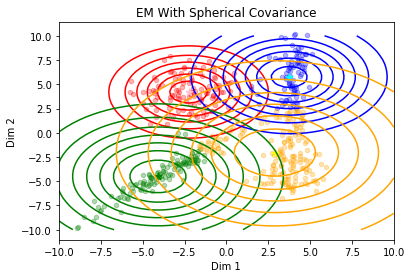

In [15]:
plot_EM_means(mu, cov, resp, train_data, name='EM_Spherical_img', title='EM With Spherical Covariance')

In [16]:
# Compute loss
_, test_loss = compute_loss(test_data, pi, mu, cov)


print("train loss: {}".format(loss))
print("test loss: {}".format(test_loss))

train loss: -5.456774058854035
test loss: -5.498615299201781


In [17]:
def general_EM(data, init_mu, init_resp):
    #  Initialize variables
    n, d = data.shape
    mu_list = [init_mu]
    pi_list = [np.array([init_resp.tolist().count(i)/n for i in range(NUM_MEANS)])]
    cov_list = [np.array([np.cov(data[init_resp==i].T) for i in range(NUM_MEANS)])]

    losses = []
    for iter_em in range(NUM_ITER):
        pi = pi_list[iter_em]
        mu = mu_list[iter_em]
        cov = cov_list[iter_em]

        # E Step
        resp, loss = compute_loss(data, pi, mu, cov)
        losses.append(loss)

        if iter_em > 1:
            if losses[iter_em] - losses[iter_em-1] < EPSILON:
                break

        # M Step
        new_pi = resp.mean(axis=0)
        pi_list.append(new_pi)

        new_mu = np.dot(resp.T, data)/resp.T.sum(axis=1, keepdims=True)
        mu_list.append(new_mu)

        new_cov = np.empty((NUM_MEANS, d, d))
        for k in range(NUM_MEANS):
            diff = train_data - mu[k]
            new_cov[k] = np.dot(resp[:, k] * diff.T, diff) / np.sum(resp, axis=0)[k]

        mu_list.append(new_mu)
        cov_list.append(new_cov)
        pi_list.append(new_pi)

        #print(new_pi)
        #print(new_mu)
        #print(new_cov)

        print('log likelihood for iteration {0}: {1}'.format(iter_em, loss))

    return pi_list, mu_list, cov_list, losses, resp

In [18]:
#  Initialize variables using values from before
pi_list, mu_list, cov_list, losses, resp = general_EM(train_data, init_mu, init_resp)

log likelihood for iteration 0: -4.885915608576327
log likelihood for iteration 1: -4.810022501923208
log likelihood for iteration 2: -4.780000250656338
log likelihood for iteration 3: -4.760178583328618
log likelihood for iteration 4: -4.754859672263935
log likelihood for iteration 5: -4.749891813328842
log likelihood for iteration 6: -4.748372617884781
log likelihood for iteration 7: -4.744455110766376
log likelihood for iteration 8: -4.743052258650259
log likelihood for iteration 9: -4.74129601260826
log likelihood for iteration 10: -4.740714256712952
log likelihood for iteration 11: -4.739537833342556
log likelihood for iteration 12: -4.739180766854175
log likelihood for iteration 13: -4.73862257520653
log likelihood for iteration 14: -4.738467062962278
log likelihood for iteration 15: -4.737341516177585
log likelihood for iteration 16: -4.73703956388084
log likelihood for iteration 17: -4.736489113944308
log likelihood for iteration 18: -4.736358083602339
log likelihood for iterat

In [19]:
# Final Params
mu = mu_list[-1]
cov = cov_list[-1]
pi = pi_list[-1]

In [20]:
#  Get cluster means, covs and proportions
print('EM Mean: \n {}'.format(mu))
print('EM Covariance: \n {}'.format(cov))
print('EM Mixing Prop: \n {}'.format(pi))

EM Mean: 
 [[-2.03362808  4.17322098]
 [ 3.99842691  4.31407216]
 [-3.04601356 -3.51939569]
 [ 3.79991161 -3.56461035]]
EM Covariance: 
 [[[ 2.90822647  0.20884479]
  [ 0.20884479  2.75687801]]

 [[ 0.19999577  0.1994303 ]
  [ 0.1994303   9.98644417]]

 [[ 6.32588246  6.12999882]
  [ 6.12999882  6.25775161]]

 [[ 0.84780027  0.05951501]
  [ 0.05951501  2.3979021 ]]]
EM Mixing Prop: 
 [ 0.25158705  0.23609882  0.30633342  0.20598072]


In [21]:
# Compute loss
_, test_loss = compute_loss(test_data, pi, mu, cov)


print("train loss: {}".format(loss))
print("test loss: {}".format(test_loss))

train loss: -5.456774058854035
test loss: -4.901712750320776


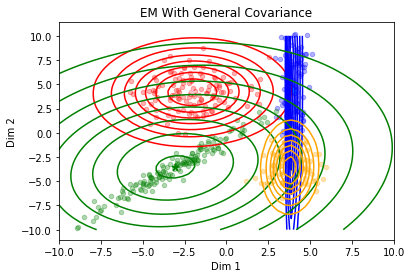

In [22]:
#  Plot results
plot_EM_means(mu, cov, resp, train_data, name='EM_General_img', title='EM With General Covariance')